In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from CNNimagegen import create_image_updown_vol
from CNNimagegen import create_image_side_vol
from CNNimagegen import create_image_updown_price
from CNNimagegen import create_image_updown_vol_mid
from CNNimagegen import create_image_updown_vol_mid_triple_l10
from CNNimagegen import create_image_updown_vol_mid_triple_l5
from CNNimagegen import create_image_updown_vol_mid_triple_l3
from CNNimagegen import data_frame_organise

In [2]:
df = pd.read_csv(r"Stocks\MSFT\cleaned_data\MSFT_2019-01-03_34200000_57600000_orderbook_10.csv")
df = data_frame_organise(df)


c:\Users\dbjac\Desktop\CNN\CNNimagegen.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill
c:\Users\dbjac\Desktop\CNN\CNNimagegen.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.

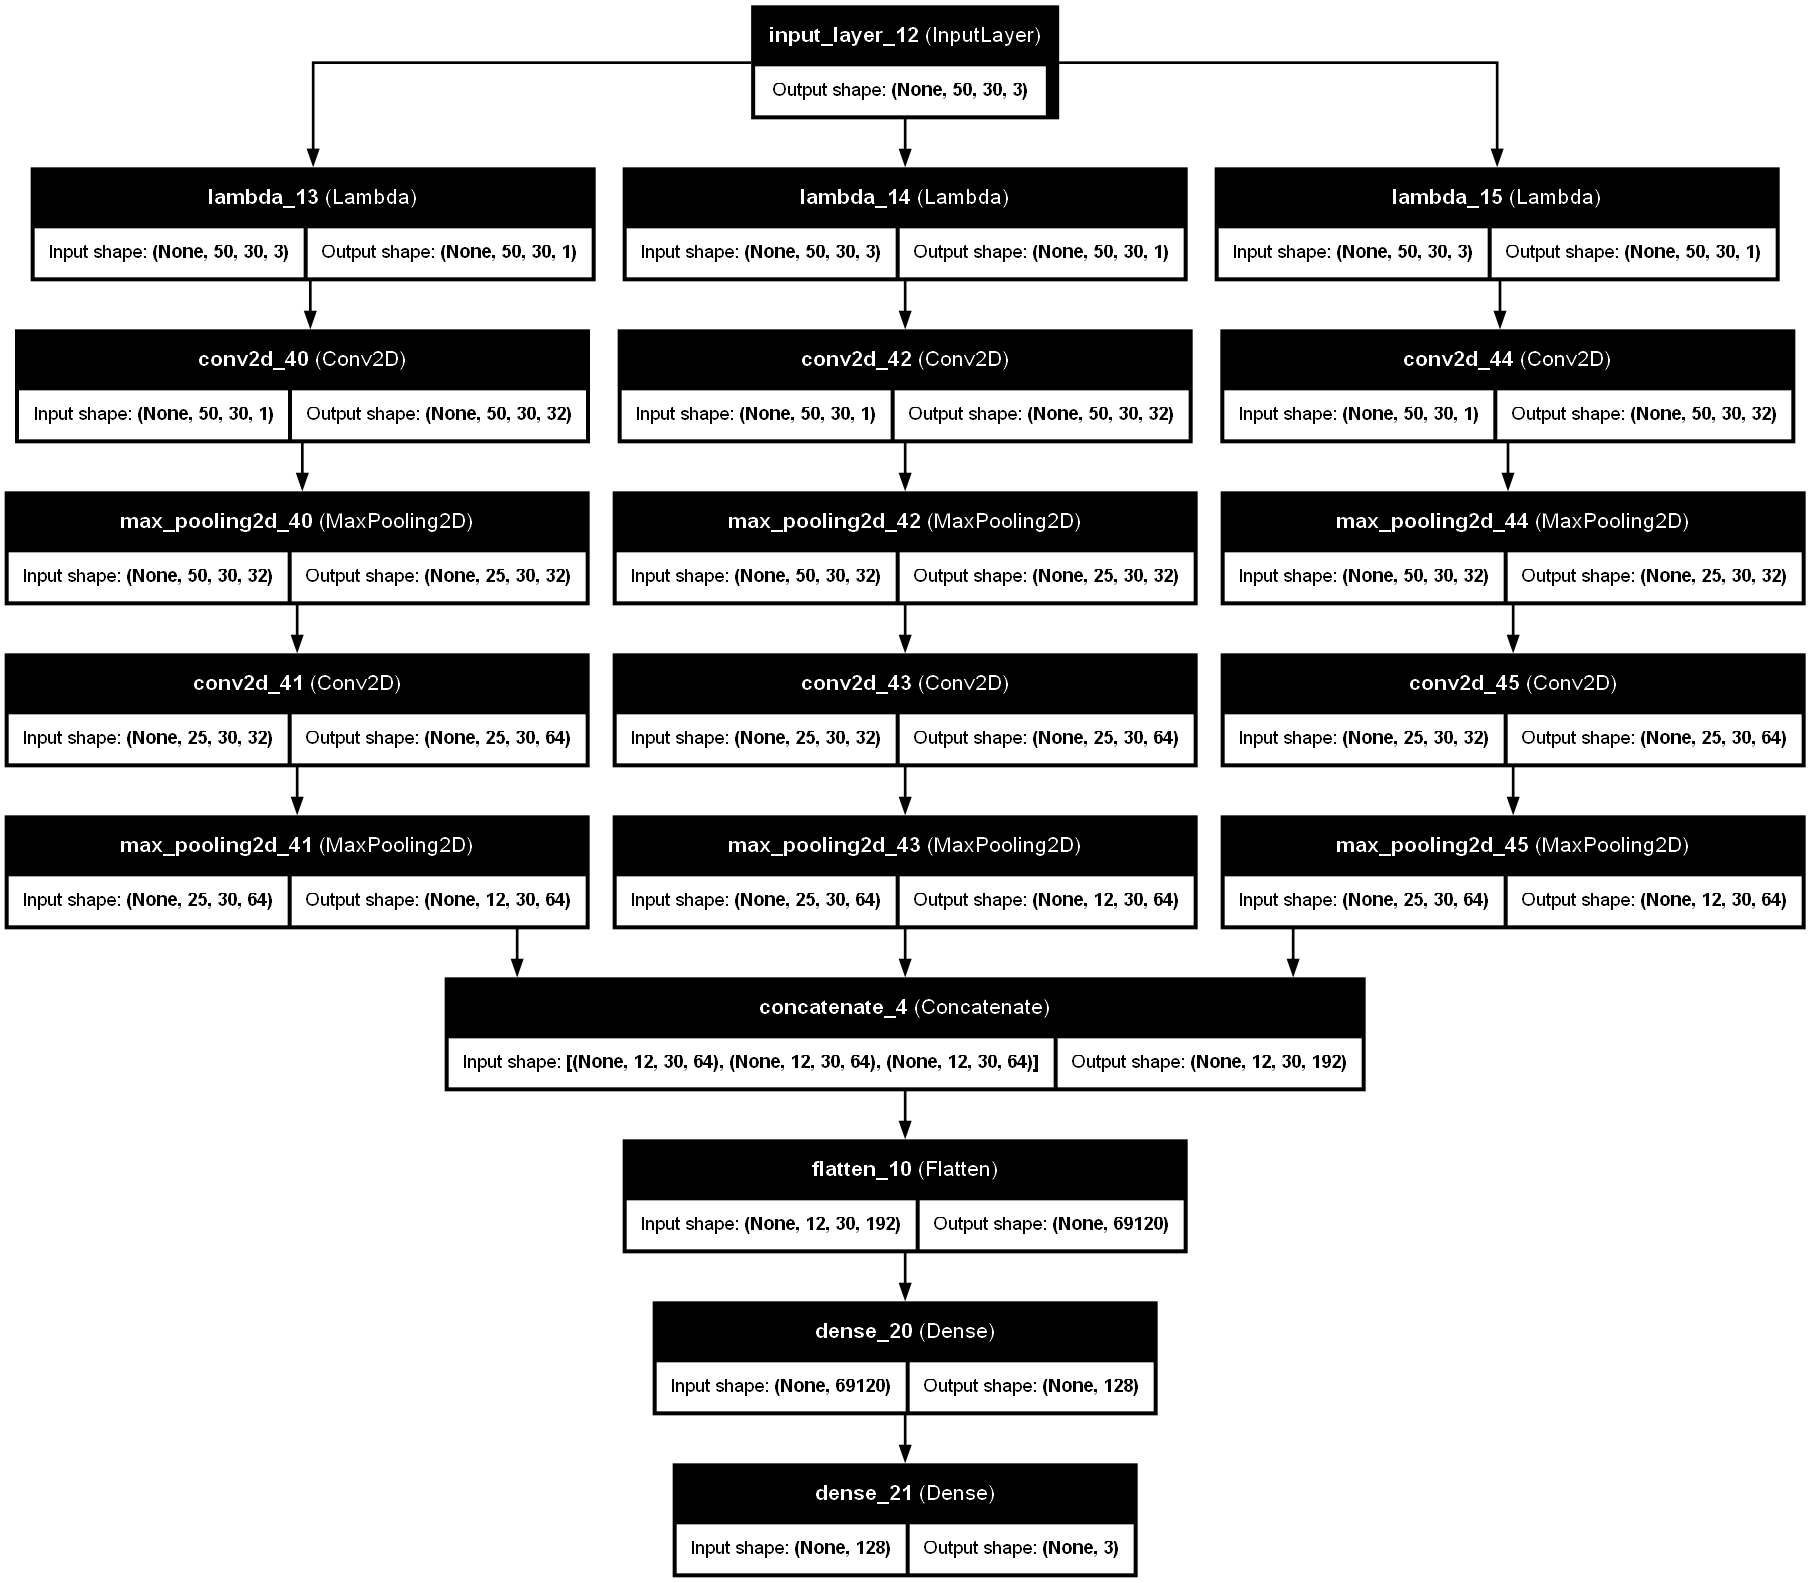

In [42]:

def create_cnn_2d_model_triple_channel(input_shape):
    inputs = layers.Input(shape=input_shape)

    green_channel = layers.Lambda(lambda x: x[:, :, :, 1:2])(inputs)  # Mid-price (Green, channel 1)
    red_channel = layers.Lambda(lambda x: x[:, :, :, 0:1])(inputs)    # Ask (Red, channel 0)
    blue_channel = layers.Lambda(lambda x: x[:, :, :, 2:3])(inputs)   # Bid (Blue, channel 2)

    green = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(green_channel)
    green = layers.MaxPooling2D((2, 1))(green)
    green = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(green)
    green = layers.MaxPooling2D((2, 1))(green)

    red = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(red_channel)
    red = layers.MaxPooling2D((2, 1))(red)
    red = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(red)
    red = layers.MaxPooling2D((2, 1))(red)

    blue = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(blue_channel)
    blue = layers.MaxPooling2D((2, 1))(blue)
    blue = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(blue)
    blue = layers.MaxPooling2D((2, 1))(blue)

    concatenated = layers.Concatenate()([green, red, blue])

    flat = layers.Flatten()(concatenated)
    dense = layers.Dense(128, activation='relu')(flat)
    outputs = layers.Dense(3, activation='softmax')(dense) 

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

cnn3 = create_cnn_2d_model_triple_channel((50,30,3))

tf.keras.utils.plot_model(cnn3, to_file='triple_cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)


In [19]:
def create_cnn_2d_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, (1, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((1, 2)),
        layers.Conv2D(64, (1, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((1, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    return model



In [6]:
def create_target(df, prediction_horizon=10):
    target = np.zeros(len(df) - prediction_horizon)  # Initialize target array

    for i in range(len(df) - prediction_horizon):
      current_price = df['Mid'].iloc[i]
      future_price = df['Mid'].iloc[i + prediction_horizon]

      if future_price > current_price:
          target[i] = 2  # Up
      elif future_price < current_price:
          target[i] = 0  # Down
      else:
          target[i] = 1  # Neutral

    return target

In [17]:
def train_and_evaluate(df, grid_function, lookback, batch_size, epochs, prediction_horizon,num_channels):
    num_grids = len(df) - lookback
    
    grids = [grid_function(lookback + i, lookback, df) for i in range(num_grids)]
    grids_np = np.array(grids)
    print(grids_np.shape)

    print("Grids initialized")
    grids_reshaped = grids_np.reshape(-1, grids_np.shape[1], grids_np.shape[2], num_channels)
    
    # Targets
    targets = create_target(df,prediction_horizon) 

    # Train-test split
    train_size = int(len(grids_reshaped) * 0.8)  # 80% for training
    X_train, X_test = grids_reshaped[:train_size], grids_reshaped[train_size:]
    y_train, y_test = targets[:train_size], targets[train_size:]

    # Input shape
    input_shape = X_train.shape[1:]
    if num_channels == 1:
        model = create_cnn_2d_model(input_shape)  # Your CNN model creation function
    elif num_channels == 3:
        model = create_cnn_2d_model_triple_channel(input_shape)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Training Model")

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Loss: {loss:.4f}')

    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1) #Axis 1 is for each sample
    accuracy = accuracy_score(y_test.astype(int), predicted_labels)
    print(f"Test Accuracy (using predictions): {accuracy}")

    #Print classification report
    print(classification_report(y_test.astype(int),predicted_labels))

    #Print confusion matrix
    print(confusion_matrix(y_test.astype(int),predicted_labels))

    # Compare with model.evaluate (should be the same)
    loss, accuracy_eval = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy (using model.evaluate): {accuracy_eval}")

    
    return history,model


In [8]:
def test_and_evaluate(df, grid_function, lookback, batch_size, epochs, num_channels):
    num_grids = len(df) - lookback
    #DEBUG
    og_grid = grid_function(lookback,lookback,df)
    # Targets
    sample_target = df["Target"].iloc[lookback] + 1
    print(sample_target)

    grids = [grid_function(lookback + i, lookback, df) for i in range(num_grids)]
    grids_np = np.array(grids)
    print(grids_np.shape)

    print("Grids initialized")
    grids_reshaped = grids_np.reshape(-1, grids_np.shape[1], grids_np.shape[2], num_channels)
    print(grids_reshaped.shape)
    re_grid = grids_reshaped[0]
    
    

    return og_grid , re_grid
    
    

    


In [ ]:

lookback = 10
batch_size = 64
epochs = 10
prediction_horizon = 10

history_v5,model_5 = train_and_evaluate(df, create_image_updown_vol_mid_triple_l10, lookback,batch_size,epochs,prediction_horizon,3)
print("Model 5 complete")



In [ ]:
history_v6 = train_and_evaluate(df, create_image_updown_vol_mid_triple_l5, lookback,batch_size,epochs,prediction_horizon,3)
print("Model 6 complete")



In [ ]:
history_v7,model_v7 = train_and_evaluate(df, create_image_updown_vol_mid_triple_l3, lookback,batch_size,epochs,prediction_horizon,3)
print("Model 7 complete") 

In [32]:
lookback = 10

num_grids = len(df) - lookback

grids = [create_image_updown_vol_mid(lookback + i, lookback, df) for i in range(num_grids)]
grids_np = np.array(grids)
print(grids_np.shape)

print("Grids initialized")

grids_reshaped = grids_np.reshape(-1, grids_np.shape[1], grids_np.shape[2], 1)

# Targets
targets = create_target(df,prediction_horizon) 

# Train-test split
train_size = int(len(grids_reshaped) * 0.8)  # 80% for training
X_train, X_test = grids_reshaped[:train_size], grids_reshaped[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Input shape
input_shape = X_train.shape[1:]



(197990, 50, 30)
Grids initialized


In [33]:

model = create_cnn_2d_model(input_shape)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Training Model")

# Train the model
history = model.fit(
X_train, y_train,
epochs=epochs,
batch_size=batch_size,
validation_data=(X_test, y_test),
verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss:.4f}')

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1) #Axis 1 is for each sample
accuracy = accuracy_score(y_test.astype(int), predicted_labels)
print(f"Test Accuracy (using predictions): {accuracy}")

#Print classification report
print(classification_report(y_test.astype(int),predicted_labels))

#Print confusion matrix
print(confusion_matrix(y_test.astype(int),predicted_labels))

# Compare with model.evaluate (should be the same)
loss, accuracy_eval = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (using model.evaluate): {accuracy_eval}")


Training Model
Epoch 1/3
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 281s 56ms/step - accuracy: 0.5399 - loss: 0.9894 - val_accuracy: 0.5466 - val_loss: 0.9657
Epoch 2/3
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 291s 59ms/step - accuracy: 0.5975 - loss: 0.8887 - val_accuracy: 0.5618 - val_loss: 0.9394
Epoch 3/3
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 290s 59ms/step - accuracy: 0.6204 - loss: 0.8471 - val_accuracy: 0.5820 - val_loss: 0.8946
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6061 - loss: 0.8636
Accuracy: 58.20%
Loss: 0.8946
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
Test Accuracy (using predictions): 0.5820243446638719
              precision    recall  f1-score   support

           0       0.58      0.72      0.64     14698
           1       0.57      0.17      0.26     10074
           2       0.59      0.73      0.65     14826

    accuracy                           0.58     39598
   macro avg       0.58      0.54      0.52     39598
weighted avg       0.58      0.58      0.55     39598

[[

In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Training Model")

# Train the model
history = model.fit(
X_train, y_train,
epochs=5,
batch_size=batch_size,
validation_data=(X_test, y_test),
verbose=1
)


Training Model
Epoch 1/5
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 335s 67ms/step - accuracy: 0.6597 - loss: 0.7729 - val_accuracy: 0.5997 - val_loss: 0.8807
Epoch 2/5
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 281s 57ms/step - accuracy: 0.6726 - loss: 0.7466 - val_accuracy: 0.6126 - val_loss: 0.8602
Epoch 3/5
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 292s 59ms/step - accuracy: 0.6881 - loss: 0.7185 - val_accuracy: 0.6166 - val_loss: 0.8544
Epoch 4/5
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 286s 58ms/step - accuracy: 0.7005 - loss: 0.6929 - val_accuracy: 0.6089 - val_loss: 0.9052
Epoch 5/5
4950/4950 ━━━━━━━━━━━━━━━━━━━━ 281s 57ms/step - accuracy: 0.7135 - loss: 0.6688 - val_accuracy: 0.6148 - val_loss: 0.8842


In [31]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss:.4f}')

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1) #Axis 1 is for each sample
accuracy = accuracy_score(y_test.astype(int), predicted_labels)
print(f"Test Accuracy (using predictions): {accuracy}")

#Print classification report
print(classification_report(y_test.astype(int),predicted_labels))

#Print confusion matrix
print(confusion_matrix(y_test.astype(int),predicted_labels))

# Compare with model.evaluate (should be the same)
loss, accuracy_eval = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (using model.evaluate): {accuracy_eval}")

1238/1238 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6362 - loss: 0.8373
Accuracy: 61.48%
Loss: 0.8842
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
Test Accuracy (using predictions): 0.6147785241678873
              precision    recall  f1-score   support

           0       0.64      0.70      0.67     14698
           1       0.55      0.30      0.38     10074
           2       0.61      0.75      0.68     14826

    accuracy                           0.61     39598
   macro avg       0.60      0.58      0.58     39598
weighted avg       0.61      0.61      0.60     39598

[[10251  1325  3122]
 [ 3248  2993  3833]
 [ 2566  1160 11100]]
Test Accuracy (using model.evaluate): 0.6147785186767578


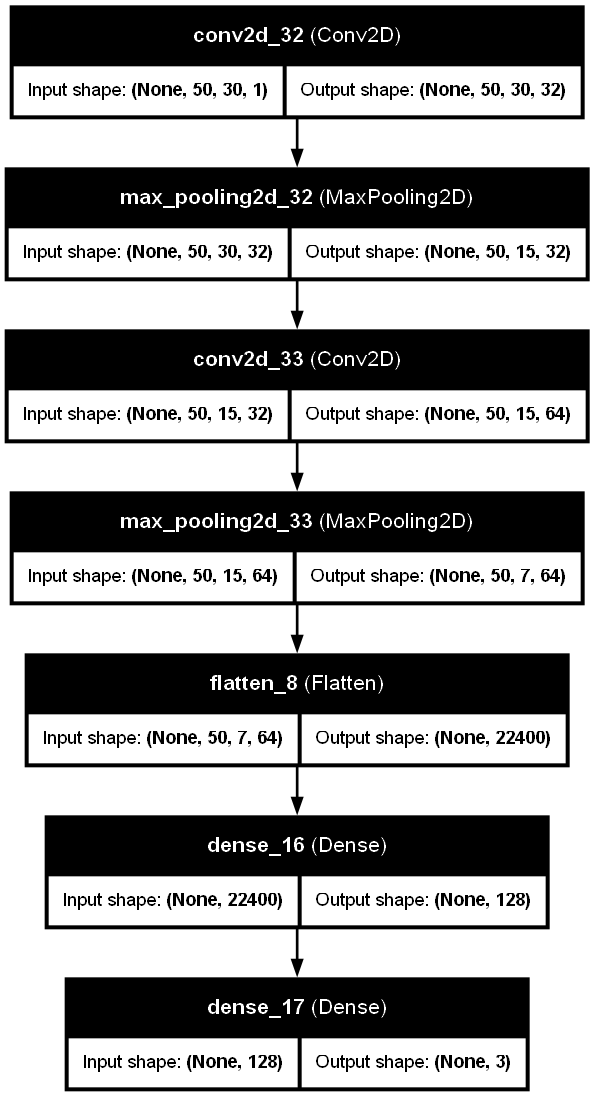

In [36]:

tf.keras.utils.plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)


In [22]:

history_v2 = train_and_evaluate(df, create_image_side_vol, lookback,batch_size,epochs,10,1)
print("Model 2 complete")

(197990, 50, 30)
Grids initialized


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 15, 32)`, `kernel shape=(50, 1, 32, 64)`, `dilation_rate=[1 1]`.

In [ ]:
history_v3 = train_and_evaluate(df, create_image_updown_price, lookback,batch_size,epochs,1)
print("Model 3 complete")